# Atividade 3 - Árvore de Decisão

Código em Python para estudo do modelo de classificação Árvore de Decisão e otimização de hiperparâmetros, conforme proposta da atividade 3 da disciplina de Machine Learning do curso de Ciência de Dados e Big Data da PUC-MG.

**Professor:** Hugo de Paula 

**Aluno:** Carlos Alberto Rocha Cardoso

Setembro de 2019 

##Bibliotecas e parametrização do ambiente

In [1]:
!pip install pydotplus
!pip install dtreeviz

In [0]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from time import time
import pydotplus
from IPython.display import Image
from dtreeviz.trees import *

In [0]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('precision', 2)

##Importação dos dados

Para essa atividade foi utilizado o arquivo **Atividade 3 - Bases.xlsx** fornecido pelo professor como material da disciplina. Esse arquivo contém dados de consumidores utilizados para predição de seu perfil de compra.

In [5]:
uploaded = files.upload()

Saving Atividade 3 - Bases.xlsx to Atividade 3 - Bases (2).xlsx


In [0]:
usuarios = pd.read_excel("Atividade 3 - Bases.xlsx", sheet_name=0)

##Análise Descritiva

In [7]:
print("Shape:{0}".format(usuarios.shape))
print("\nAtributos:\n{0}".format(usuarios.dtypes))

idx_cat = usuarios.dtypes[usuarios.dtypes == 'object'].index

print("\nAtributos Categóricos:\n{0}".format(usuarios[idx_cat].describe()))
print("\nAtributos Numéricos:\n{0}".format(usuarios.describe()))


Shape:(661, 11)

Atributos:
ID_usuário                      int64
Gênero                         object
Idade                           int64
Estado_civil                   object
Atividade_no_site              object
Pesquisou_eletronicos_12m      object
Comprou_eletronicos_12m        object
Pesquisou_mídia_digital_18m    object
Comprou_mídia_digital_18m      object
Forma_pagamento                object
Adoção_eReader                 object
dtype: object

Atributos Categóricos:
       Gênero Estado_civil Atividade_no_site Pesquisou_eletronicos_12m  \
count     661          661               661                       661   
unique      2            2                 3                         2   
top         M            C        Esporádico                       Sim   
freq      346          381               424                       613   

       Comprou_eletronicos_12m Pesquisou_mídia_digital_18m  \
count                      661                         661   
unique               

O atributo **ID_usuário** não será utilizado na análise e por isso será **descartado**.

In [0]:
del usuarios["ID_usuário"]

Verificando consistência dos atributos categóricos:

* Forma_pagamento
* Atividade_no_site

In [9]:
colunas = list(['Forma_pagamento', 'Atividade_no_site'])

for c in colunas:
  print('Valores únicos do atributo {0}:\n{1}'.format(c,usuarios[c].unique()), end="\n\n")

Valores únicos do atributo Forma_pagamento:
['Transferência' 'Website' 'Cartão de crédito' 'Boleto bancário']

Valores únicos do atributo Atividade_no_site:
['Esporádico' 'Intermitente' 'Frequênte']



Distribuição do atributo classificador na base

In [10]:
usuarios.groupby(["Adoção_eReader"])["Adoção_eReader"].count()

Adoção_eReader
Early Adopter     205
Early Majority    186
Innovator          98
Late Majority     172
Name: Adoção_eReader, dtype: int64

Após análise **não foram** identificadas dados faltantes, outliers (caso do atributo 'Idade') ou mesmo inconsitência nos atributos categóricos.

A única alteração no dataset utilizado para modelagem foi a **exclusão do atributo "ID_usuário"**.

Existe um certo desbalanceamento na base, a classe Innovator possui praticamente metade dos registros que as outras classes.


##Modelagem

###Codificação das variáveis categóricas

In [0]:
X_dict = usuarios.iloc[:,0:(usuarios.shape[1]-1)].T.to_dict().values()
vect = DictVectorizer(sparse=False)
X = vect.fit_transform(X_dict)
feature_names = vect.feature_names_


###Codificação das classes de resultado

In [0]:
le = LabelEncoder()
y = le.fit_transform(usuarios.iloc[:,(usuarios.shape[1] - 1)])
target_classes = le.classes_

###Particionamento dos dados em treino e teste

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.30)

print("Shape Dados de Treinamento: {0}".format(X_train.shape))
print("Labels: {0}".format(y_train.shape))

Shape Dados de Treinamento: (462, 20)
Labels: (462,)


###Avaliação do modelo

In [0]:
#Função que imprime indicadores para avaliação do modelo
def avaliacao_modelo(estimador, X_train, X_test, y_train, y_test, target_classes):
 
  y_pred = estimador.predict(X_train)
  print("Acurácia de previsão Treinamento:", accuracy_score(y_train, y_pred))
  print(classification_report(y_train, y_pred))

  print("Matriz de confusão do Treinamento")
  cnf_matrix = confusion_matrix(y_train, y_pred)
  cnf_table = pd.DataFrame(data=cnf_matrix, index=target_classes, columns=[x + "(prev)" for x in target_classes ])
  print(cnf_table)

  y_pred = estimador.predict(X_test)
  print("Acurácia de previsão Teste:", accuracy_score(y_test, y_pred))
  print(classification_report(y_test, y_pred))

  print("Matriz de confusão do Teste")
  cnf_matrix = confusion_matrix(y_test, y_pred)
  cnf_table = pd.DataFrame(data=cnf_matrix, index=target_classes, columns=[x + "(prev)" for x in target_classes ])
  print(cnf_table)

 
  

O primeiro passo foi executar o modelo de árvore de decisão utilizando o critério de entropia sem alterar os demais parâmetros

In [15]:
#Modelo Árvore de decisão sem otimização dos parâmetros
dtc = DecisionTreeClassifier(random_state=0, criterion='entropy')

dtc = dtc.fit(X_train, y_train)

print("Decision Tree Score:", dtc.score(X_train, y_train))
print("Profundidade:", dtc.get_depth())
print("Nós Folhas:", dtc.get_n_leaves())

avaliacao_modelo(dtc, X_train, X_test, y_train, y_test, target_classes)

Decision Tree Score: 0.9004329004329005
Profundidade: 16
Nós Folhas: 198
Acurácia de previsão Treinamento: 0.9004329004329005
              precision    recall  f1-score   support

           0       0.83      0.99      0.90       139
           1       0.89      0.91      0.90       129
           2       0.97      0.83      0.89        69
           3       1.00      0.83      0.91       125

    accuracy                           0.90       462
   macro avg       0.92      0.89      0.90       462
weighted avg       0.91      0.90      0.90       462

Matriz de confusão do Treinamento
                Early Adopter(prev)  Early Majority(prev)  Innovator(prev)  \
Early Adopter                   138                     1                0   
Early Majority                   12                   117                0   
Innovator                         6                     6               57   
Late Majority                    11                     8                2   

              

In [16]:
viz = dtreeviz(dtc,
                X_train,
                y_train,
                target_name="Adoção_eReader",
                feature_names=feature_names,
                class_names=[x for x in target_classes],
                fancy=True)  
viz.view()

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


In [17]:
dot_data = tree.export_graphviz(dtc, out_file=None, 
                                  feature_names=feature_names ,  
                                  rounded =True,
                                  filled=True,
                                  class_names=[x for x in target_classes])

graph = pydotplus.graph_from_dot_data(dot_data)  

Image(graph.create_png())

Conforme avaliação do treino e observamos um **overfiting de 0.39**

A seguir foi executada a otimização de hiperparâmetros utilizando os métodos de random e grid search.

Abaixo parâmetros testados e justificativa:

* **max_depth** usado para definir a profundidade ou quantidade de níveis máximos da árvore. Definido range de 1-16 com base na profundidade da árvore gerada no modelo anterior.

* **max_features** Range de 1-9 com base no número máximo de atributos disponíveis no dataset.

* **max_leaf_nodes** começou em 198, quantidade de nós folha gerados pelo modelo anterior, porém foi reduzido após alguns testes de execução.

* **criterion** com base nos dois critérios disponíveis para o modelo DecisionTreeClassifier: entropy e gini

* **min_samples_leaf** definido arbitrariamente e ajustado conforme testes.

* **class_weight** definido como "balanced" tendo em vista o desbalanceamento da classe innovation

Após vários testes verificou-se que a inclusão de muitos parâmetros pode tornar o processo de search muito lento e inclusive piorar o resultado. 

Abaixo os parâmetros definidos para execução do search ao final dos testes:

* **class_weight**='balanced'
* **criterion**='gini'
* **max_depth**=1-16
* **max_leaf_nodes**=2-25

###Executando random search para otimização dos hiperparâmetros

In [18]:
#Instanciando o modelo
model = DecisionTreeClassifier(random_state=0, class_weight='balanced', criterion='gini')

rs_param = {
                  'max_depth'    : randint(1, 16),
#                  'max_features' : randint(1, 9),
#                  'min_samples_leaf' : randint(1, 50),
                  'max_leaf_nodes' : randint(2, 25),
#                  'criterion': ['entropy','gini']
             }

start = time()
rs = RandomizedSearchCV(model, rs_param, n_iter=100, cv=10, iid=False, n_jobs=-1, scoring="accuracy")
rs.fit(X_train, y_train)

print("Random Search Best Score:",rs.best_score_)
print("Random Search Best Score:",rs.best_params_)
print("Tempo de execução:%.2f segundos" % (time()-start))



Random Search Best Score: 0.6024428285609793
Random Search Best Score: {'max_depth': 11, 'max_leaf_nodes': 6}
Tempo de execução:4.29 segundos


###Executando grid search para otimização dos hiperparâmetros

In [19]:
gs_param = {    
                  'max_depth'    : list(range(1, 16)),
#                 'max_features' : list(range(1, 9)),
#                  'min_samples_leaf' : list(range(1, 50)),
                  'max_leaf_nodes' : list(range(2, 25)),
#                  'criterion': ['entropy','gini']
             }

start = time()
gs = GridSearchCV(model, gs_param, cv=10, iid=False, scoring="accuracy")
gs.fit(X_train, y_train)

print("Grid Search Best Score:", gs.best_score_)
print("Grid Search Best Paramns:",gs.best_params_)
print("Tempo de execução:%.2f segundos" % (time()-start))

Grid Search Best Score: 0.6024428285609793
Grid Search Best Paramns: {'max_depth': 3, 'max_leaf_nodes': 6}
Tempo de execução:6.10 segundos


###Selecionando o melhor estimador a partir dos resultados do random e grid search

In [20]:
usuario_tree, usuario_tree_score  = (rs.best_estimator_, rs.best_score_) if (rs.best_score_ > gs.best_score_) else (gs.best_estimator_, gs.best_score_)

print("Decision Tree Score:", usuario_tree.score(X_train, y_train))
print("Profundidade:", usuario_tree.get_depth())
print("Nós Folhas:", usuario_tree.get_n_leaves())
print("Score:", usuario_tree_score)

Decision Tree Score: 0.6341991341991342
Profundidade: 3
Nós Folhas: 6
Score: 0.6024428285609793


###Visualizando a árvore do modelo selecionado

In [0]:
viz = dtreeviz(usuario_tree,
                X_train,
                y_train,
                target_name="Adoção_eReader",
                feature_names=feature_names,
                class_names=[x for x in target_classes],
                fancy=True)  
viz.view()

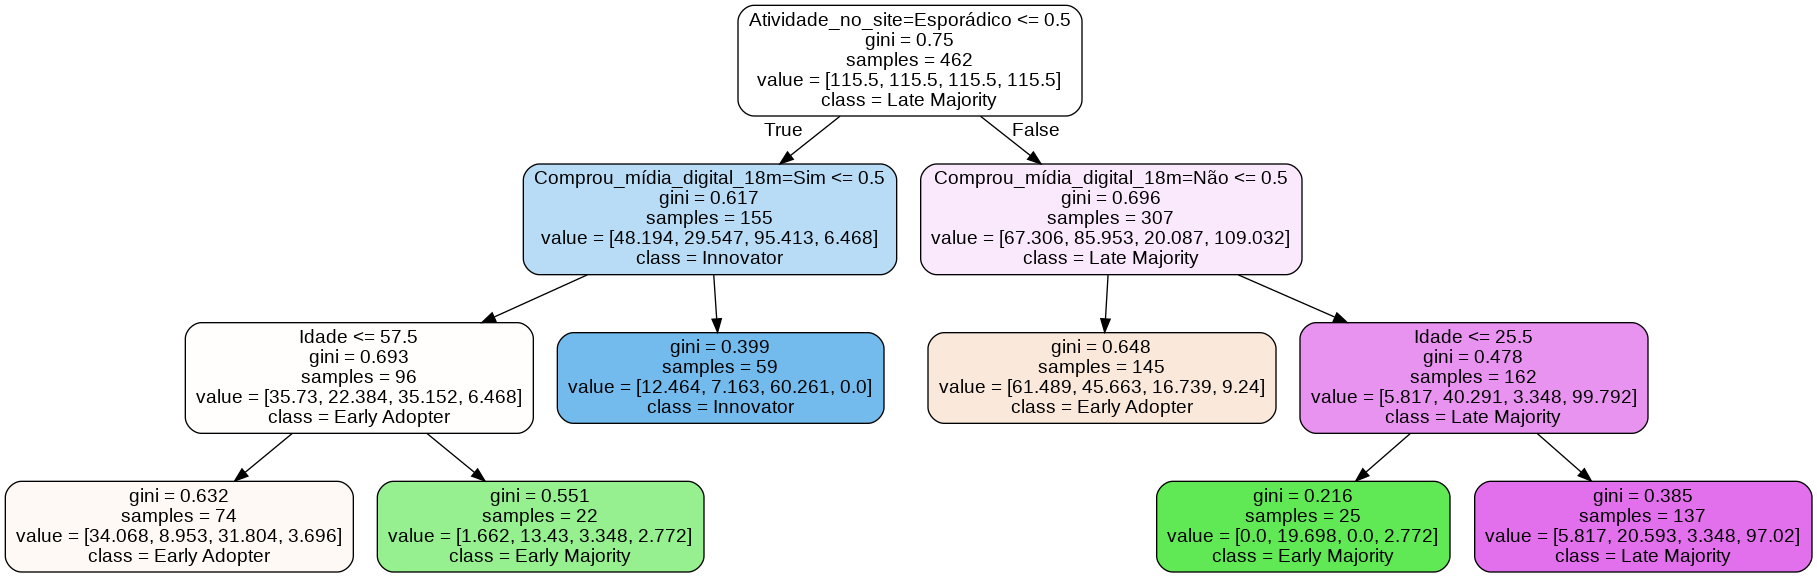

In [22]:
dot_data = tree.export_graphviz(usuario_tree, out_file=None, 
                                  feature_names=feature_names ,  
                                  rounded =True,
                                  filled=True,
                                  class_names=[x for x in target_classes])

graph = pydotplus.graph_from_dot_data(dot_data)  

Image(graph.create_png())

###Avaliação do modelo selecionado a partir da otimização de hiperparâmetros

In [23]:
avaliacao_modelo(usuario_tree, X_train, X_test, y_train, y_test, target_classes)



Acurácia de previsão Treinamento: 0.6341991341991342
              precision    recall  f1-score   support

           0       0.53      0.83      0.64       139
           1       0.79      0.29      0.42       129
           2       0.61      0.52      0.56        69
           3       0.77      0.84      0.80       125

    accuracy                           0.63       462
   macro avg       0.67      0.62      0.61       462
weighted avg       0.68      0.63      0.61       462

Matriz de confusão do Treinamento
                Early Adopter(prev)  Early Majority(prev)  Innovator(prev)  \
Early Adopter                   115                     2               15   
Early Majority                   61                    37                8   
Innovator                        29                     2               36   
Late Majority                    14                     6                0   

                Late Majority(prev)  
Early Adopter                     7  
Early Major

##Predizendo a partir da planilha com dados de Validação

In [0]:
usuarios_teste = pd.read_excel("Atividade 3 - Bases.xlsx", sheet_name=1)
usuarios_predict = pd.DataFrame(usuarios_teste["ID_usuário"])

del usuarios_teste["ID_usuário"]

X_dict = usuarios_teste.iloc[:,0:(usuarios_teste.shape[1])].T.to_dict().values()
vect = DictVectorizer(sparse=False)
X = vect.fit_transform(X_dict)

#DataFrame com predição a partir dos dados da planilha de validação  
usuarios_predict['Adoção_eReader'] = le.inverse_transform(usuario_tree.predict(X))

##Conclusão

Após iterações, testes e análises conseguiu-se o reduzir o overfiting inicial de 0.41 para 0.5, uma acurácia de 0.63 no treino e 0.58 no teste.

Apesar da acurácia relativamente baixa, as regras de classificações geradas pela árvore e verificadas na matriz de confusão demonstram que a grande maioria dos erros ocorrem em classes próximas.

Um exemplo é que as previsões erradas da classe Innovation estão relacionadas na grande maioria com a classe Early Adopter.

Isso pode reduzir o impacto dos erros em uma possível aplicação do modelo. 